In [1]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.config import JERSEY_ATLANTIC_DATA_DIR, FIGURES_DIR
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer

2025-03-16 19:43:38.482 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


# **Data Description:**

## **Data Overview:**
The dataset consist of **5 turbines** located at the [**Jersey-Atlantic Wind Farm**](https://www.acua.com/Projects/Jersey-Atlantic-Wind-Farm.aspx), in Atlantic City, New Jersey. The was data shared by Brandon from [Leeward Renewable Energy, LLC](https://www.lreus.com/). The time period is from **March, 1st to December, 31st 2022**, with observations recorded every **10 minutes** for each turbine. The dataset includes time-stamped records of **wind speed**, **wind direction**, and **power output** (energy produced by each turbine), along with turbine identification information. Additionally, the data is used to analyze the **correlation** between wind conditions (speed and direction) and the corresponding energy output for each turbine.

## **Columns:**
1. **Turbine**: The identifier for each of the 5 turbines (T01, T02, T03, T04, T05) in the wind farm. The dataset contains data for each turbine separately, allowing for analysis of individual turbine performance.
2. **WindSpeed**: Wind speed measured in meters per second (m/s), recorded at 10 min regular intervals. This feature help to assess the potential energy generation capacity of each turbine under varying wind conditions.
3. **PowerkW**: The energy output from each turbine, measured in kilowatts (kW). This is a key performance indicator that reflects the efficiency of each turbine in converting wind energy into electrical power.
4. **WindDirection**: The direction from which the wind is blowing, measured in degrees (0° to 360°). Wind direction data help understanding how the positioning of turbines affects their energy generation efficiency. and for modeling wind farm layout optimization.
5. **Timestamp**: Time of measurement, recorded every 10 minutes from March to December 2022. This time series data allows for the analysis of trends, patterns, and seasonal variations in wind conditions and turbine performance.

## **Data Analysis Focus:**
1. **Resampling**: The data is resampled to different time periods (e.g., hourly, daily, weekly, monthly) to understand how wind conditions and power output change over time and to assess turbine performance under different wind patterns.
   
2. **Correlation Analysis**: There is a focus on examining the relationship between wind speed and power output, with a strong correlation observed (e.g., 0.97). This indicates that as wind speed increases, the energy output tends to rise as well, which is typical for wind turbines.

3. **Wind Roses**: Wind roses are used to visualize the distribution of wind speed and direction across different turbines. This helps in understanding the prevailing wind patterns and their impact on turbine performance.

4. **Turbine-to-Turbine Correlation**: The analysis includes investigating how similar the performance of different turbines is, with correlations around **0.9** suggesting that turbines in the same wind farm are generally experiencing similar conditions and producing similar energy outputs.

5. **Visualization**: Various plots, including line plots for time-based analysis, heatmaps for correlation analysis, and wind rose plots for spatial wind pattern analysis, are used to explore the data and interpret turbine performance under varying conditions.

---
## **Research question**
- What **atmospheric conditions** and turbine-specific factors (e.g., wake effects, yaw misalignment, or local turbulence) explain the differences in wind rose patterns across turbines, despite their strong correlation in wind speed and power output?

# Load Jersey Atlantic Wind Farm Data
## File path

In [2]:
jersy_atlantic_path = JERSEY_ATLANTIC_DATA_DIR / 'JAW_Wind_Data.xlsx'

## Loading Dataset

In [3]:
df = pd.read_excel(jersy_atlantic_path)

In [4]:
df.head(10)

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW
0,T01,2022-03-01 00:00:00,4.5,219.0,187.0
1,T02,2022-03-01 00:00:00,4.9,151.0,282.0
2,T03,2022-03-01 00:00:00,6.0,276.0,319.0
3,T04,2022-03-01 00:00:00,4.1,166.0,171.0
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0
5,T01,2022-03-01 00:10:00,4.2,216.0,149.0
6,T02,2022-03-01 00:10:00,5.2,154.0,332.0
7,T03,2022-03-01 00:10:00,5.8,278.0,284.0
8,T04,2022-03-01 00:10:00,4.0,162.0,163.0
9,T05,2022-03-01 00:10:00,5.0,166.0,-10.0


In [5]:
# Check timestamps with missing data
# missing_timestamps = df[df.isna().any(axis=1)]['StampTime'].unique()
# missing_timestamps

## Extract Minute, Hour & day of the year -> create cyclic encodings

In [6]:
# df['date'] = df['StampTime'].dt.date
# df['time'] = df['StampTime'].dt.time

# Extract time-based features
df["Minute"] = df["StampTime"].dt.minute
df["Hour"] = df["StampTime"].dt.hour
df["DayOfYear"] = df["StampTime"].dt.dayofyear

# Cyclic encoding for time features
df["Minute_sin"] = np.sin(2 * np.pi * df["Minute"] / 60)
df["Minute_cos"] = np.cos(2 * np.pi * df["Minute"] / 60)
df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
df["Day_sin"] = np.sin(2 * np.pi * df["DayOfYear"] / 365)
df["Day_cos"] = np.cos(2 * np.pi * df["DayOfYear"] / 365)

In [7]:
# Keep only transformed time variables for PCA
time_features = ["Day_sin","Day_cos","Hour_sin", "Hour_cos", "Minute_sin", "Minute_cos"]

In [8]:
df[time_features]

,Day_sin,Day_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
0,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
1,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
2,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
3,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
4,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
...,...,...,...,...,...,...
220310,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220311,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220312,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220313,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5


# Data preprocessing: u & v vectors exploration

In [9]:
df['u_vector'] = np.sin(np.radians(df['WindDirection'])) * df['WindSpeed']
df['v_vector'] = np.cos(np.radians(df['WindDirection'])) * df['WindSpeed']

## Fill NaN for PowerKw as -10

In [10]:
df.fillna({'PowerkW':-10}, inplace=True)

## Drop StampTimes where there is completely missing data

In [11]:
# Identify timestamps where ALL turbines have missing WindSpeed data
timestamps_all_missing = df.groupby('StampTime')['WindSpeed'].apply(lambda x: x.isna().all())

# Get a list of these timestamps
timestamps_to_drop = timestamps_all_missing[timestamps_all_missing].index

# Drop rows with these timestamps
df = df[~df['StampTime'].isin(timestamps_to_drop)].reset_index(drop=True)


In [12]:
df[df['StampTime'].isin(timestamps_all_missing[timestamps_all_missing].index)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector


## Fill missing wind speed and wind vectors by calculating the mean if there is data at a given time

In [13]:
for column in ['WindSpeed', 'u_vector', 'v_vector']:
    df[column] = df.groupby('StampTime')[column]\
                                    .transform(lambda x: x.fillna(x.mean()))

## Re-calculate the Wind Direction

In [14]:
# Compute wind direction from u and v components
def compute_wind_direction(u, v):
    wind_direction = (np.degrees(np.arctan2(u, v)) + 360) % 360
    return wind_direction

# Example usage:
df['WindDirection'] = compute_wind_direction(df['u_vector'], df['v_vector'])

In [15]:
df[df.isna().any(axis=1)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector


In [16]:
np.var(df['PowerkW'])

266602.1270828768

# Unsupervised ML
## PCA
🔹 **What is Variance?**
Variance measures how much a set of data points deviate from their mean. In PCA, variance is used to **determine how much information each principal component retains from the original dataset.** The explained variance quantifies the proportion of total variability preserved in each component, helping to represent the data while minimizing redundancy.

🔹 **What is PCA?**
Principal Component Analysis (PCA) is a dimensionality reduction technique that **identifies the dominant patterns of variation in a dataset**. It finds the directions (axes) in multi-dimensional space where **variance is maximized**, allowing for a simplified yet meaningful representation of the dataset.

Instead of analyzing individual variables separately, **PCA captures how features vary in relation to one another, making it particularly useful when variables are highly correlated** (e.g., wind speed and power generation). By transforming the dataset into a new coordinate system, PCA reorients the axes
### df_times 
**['WindSpeed', 'PowerkW', Day_sin', 'Day_cos', 'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos']**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numerical columns for PCA (exclude timestamp)
wind_speed_time_features = df[['WindSpeed', 'PowerkW'] + time_features]  # Adjust if necessary

# Standardize the features before PCA
scaler = StandardScaler()
wind_speed_time_features_scaled = scaler.fit_transform(wind_speed_time_features)

# Apply PCA
pca_wind_speed_time = PCA()
pca_transformed_wind_speed_time = pca_wind_speed_time.fit_transform(wind_speed_time_features_scaled)

In [75]:
wind_speed_time_features_scaled[0]

array([-4.32110496e-01, -5.76522103e-01,  1.29016645e+00,  1.01847020e+00,
        8.24766394e-04,  1.41384645e+00, -2.26280814e-04,  1.41375646e+00])

#### Explained variance plot to determine the number of components to keep

The explained variance ratio represents **the proportion of total variance captured by each principal component (PC)**. This means each PC quantifies how much of the dataset’s variability it retains.

- For example:
    - PCA_1 explains 24.56% of the total variance.
    - PCA_2 explains 14.66% of the total variance.
    - Together, PCA_1 and PCA_2 explain 39.16% of the dataset’s variability.
    
Having two principal components (PCs) that together explain only 39.16% of the variance indicates that more components are needed to adequately describe the dataset. This suggests that the dataset has a complex structure, where variance is spread across multiple features rather than being concentrated in just one or two dominant patterns.

pca_wind_speed_time.explained_variance_ratio_

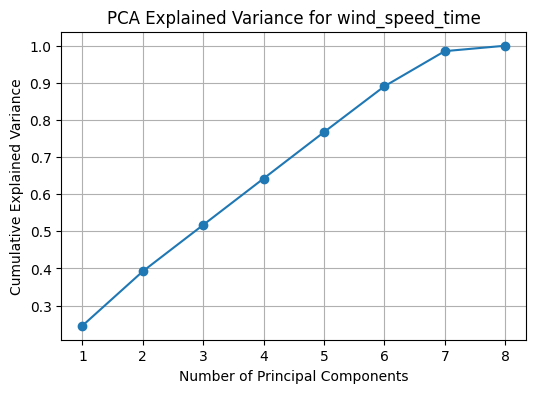

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca_wind_speed_time.explained_variance_ratio_) + 1), np.cumsum(pca_wind_speed_time.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for wind_speed_time")
plt.grid(True)
plt.show()



In [23]:
# Determine optimal number of components (e.g., keep enough to explain ~95% variance)
n_components_wind_speed_time = np.argmax(np.cumsum(pca_wind_speed_time.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components_wind_speed_time}")

Optimal number of PCA components: 7


#### Apply PCA with optimal components
- The PCA Explained Variance for wind_speed_time plot indicates that the optimal number of principal components is 7. This selection is based on the 95% variance threshold, meaning that these 7 components together explain at least 95% of the total variability in the dataset.

- By choosing 7 PCA components, we retain the most significant patterns in the data while reducing dimensionality and filtering out noise and redundancy. This ensures that the transformed dataset preserves essential information while eliminating less important variations.



In [25]:
pca_components_wind_speed_time = PCA(n_components=n_components_wind_speed_time)
pca_wind_speed_time_features = pca_components_wind_speed_time.fit_transform(wind_speed_time_features)

#### Convert PCA results to DataFrame

In [26]:
pca_columns_wst = [f"PCA_{i+1}" for i in range(n_components_wind_speed_time)]
df_pca_wst = pd.DataFrame(pca_wind_speed_time_features, columns=pca_columns_wst)
df_pca_wst["StampTime"] = df["StampTime"].values  # Retain timestamp for reference

#### 2D Scatter Plot for PCA 1 vs PCA 2

/tmp/ipykernel_10208/2723240790.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_pca_wst["PCA_1"], df_pca_wst["PCA_2"], alpha=0.6, cmap="viridis")


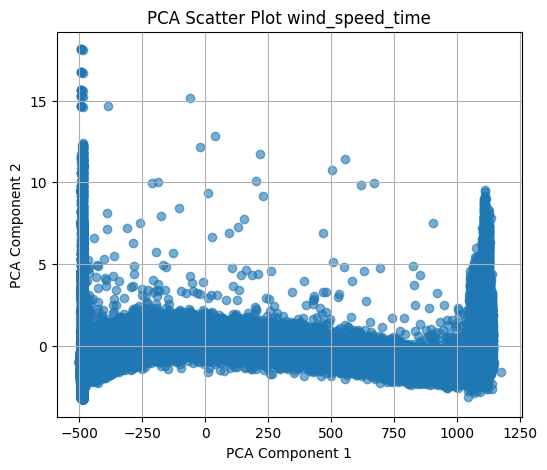

In [50]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df_pca_wst["PCA_1"], df_pca_wst["PCA_2"], alpha=0.6, cmap="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatter Plot wind_speed_time")
plt.grid(True)
plt.show()

/tmp/ipykernel_10208/39417342.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_pca_wst["PCA_4"], df_pca_wst["PCA_5"], alpha=0.6, cmap="viridis")


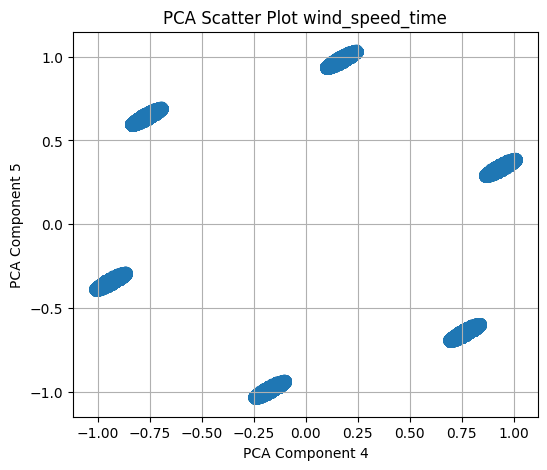

In [51]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df_pca_wst["PCA_4"], df_pca_wst["PCA_5"], alpha=0.6, cmap="viridis")
plt.xlabel("PCA Component 4")
plt.ylabel("PCA Component 5")
plt.title("PCA Scatter Plot wind_speed_time")
plt.grid(True)
plt.show()

**Plot PCA Vectors (Eigenvectors) for PCA_1 and PCA_2**

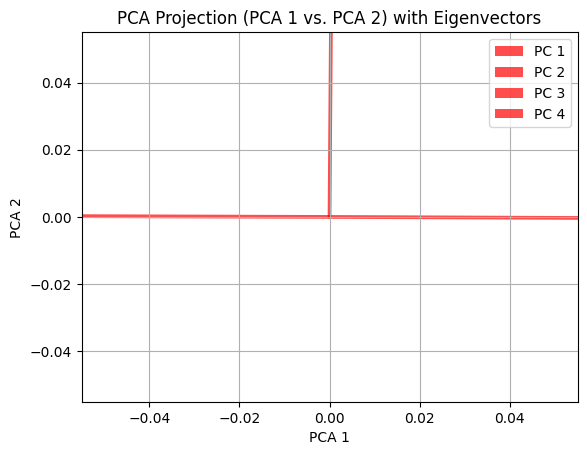

In [49]:
origin = np.zeros((2,))  # Origin for vectors
for i, comp in enumerate(pca_components_wind_speed_time.components_[:4]):  # Only taking PCA 1 & 2
    plt.quiver(*origin, comp[0], comp[1], angles='xy', scale_units='xy', scale=0.5, color='r', alpha=0.7, label=f"PC {i+1}")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection (PCA 1 vs. PCA 2) with Eigenvectors")
plt.legend()
plt.grid(True)
plt.show()

**3D Scatter Plot for PCA 1 vs. PCA 2 vs. PCA 3**

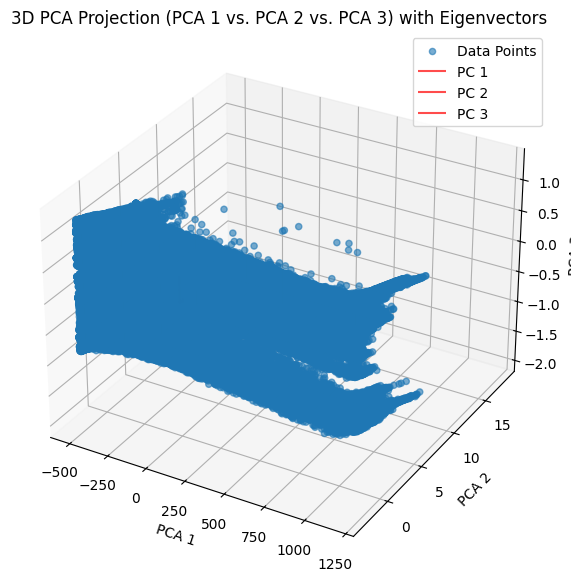

In [35]:

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_wind_speed_time_features[:, 0], pca_wind_speed_time_features[:, 1], pca_wind_speed_time_features[:, 2], alpha=0.6, label="Data Points")

# Plot PCA Vectors (Eigenvectors) for PCA_1, PCA_2, PCA_3
origin = np.zeros((3,))  # Origin for vectors
for i, comp in enumerate(pca_components_wind_speed_time.components_[:3]):  # Taking only first 3 components
    ax.quiver(*origin, *comp[:3], color='r', alpha=0.7, length=0.5, label=f"PC {i+1}")

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection (PCA 1 vs. PCA 2 vs. PCA 3) with Eigenvectors")
ax.legend()
plt.show()


#### Visualize PCA Component Contribution Heatmap

In [76]:
pca_components_wind_speed_time.components_

array([[ 5.49688722e-03,  9.99984851e-01,  1.99401113e-04,
         1.66666985e-04, -1.11343226e-04, -3.76461197e-05,
        -3.30771721e-08, -1.00881910e-07],
       [ 9.97858597e-01, -5.49594971e-03,  5.83904161e-02,
        -2.00690289e-02, -1.98801101e-02, -6.33330804e-03,
        -1.90865591e-04, -6.65092358e-04],
       [-5.92754972e-02,  2.48428652e-04,  8.50381510e-01,
        -5.20642035e-01,  3.93753206e-02,  2.66411831e-02,
         2.70028639e-03,  1.43225950e-03],
       [ 7.72194885e-05, -2.47631162e-06, -1.63402199e-03,
        -2.27649669e-03, -4.56937064e-02,  5.96997189e-02,
        -3.42143573e-01,  9.36631168e-01],
       [ 6.96868782e-04, -3.15920304e-06, -2.82072109e-03,
         2.76549893e-03, -1.27012211e-02,  5.09699947e-02,
         9.39228686e-01,  3.39225772e-01],
       [-1.44736155e-03,  1.95561055e-06, -1.34857492e-02,
        -5.31803453e-03, -3.95012809e-01,  9.14189186e-01,
        -2.38159181e-02, -8.62761496e-02],
       [ 2.26538091e-02, -1.917298

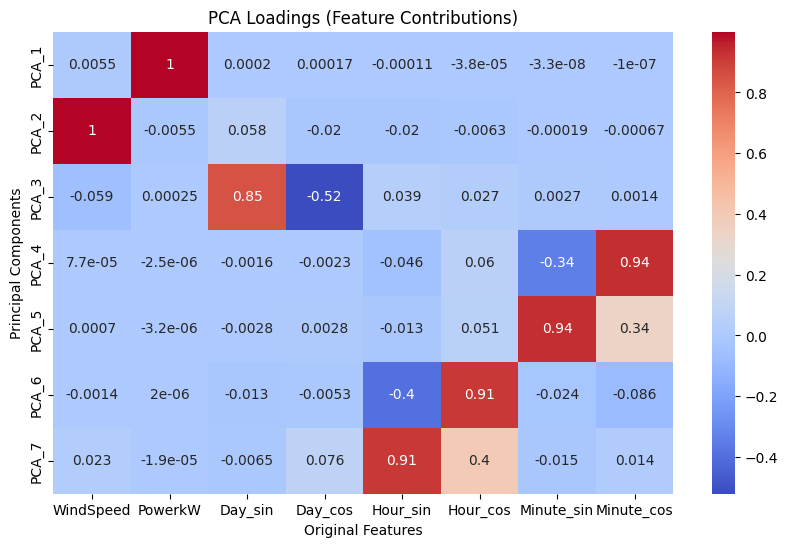

In [43]:

plt.figure(figsize=(10, 6))
sns.heatmap(pca_components_wind_speed_time.components_, cmap="coolwarm", annot=True, xticklabels=wind_speed_time_features.columns, yticklabels=pca_columns_wst)
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions)")
plt.show()

/tmp/ipykernel_10208/3924906259.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_daily = df_pca_wst.resample('H', on='StampTime').mean()


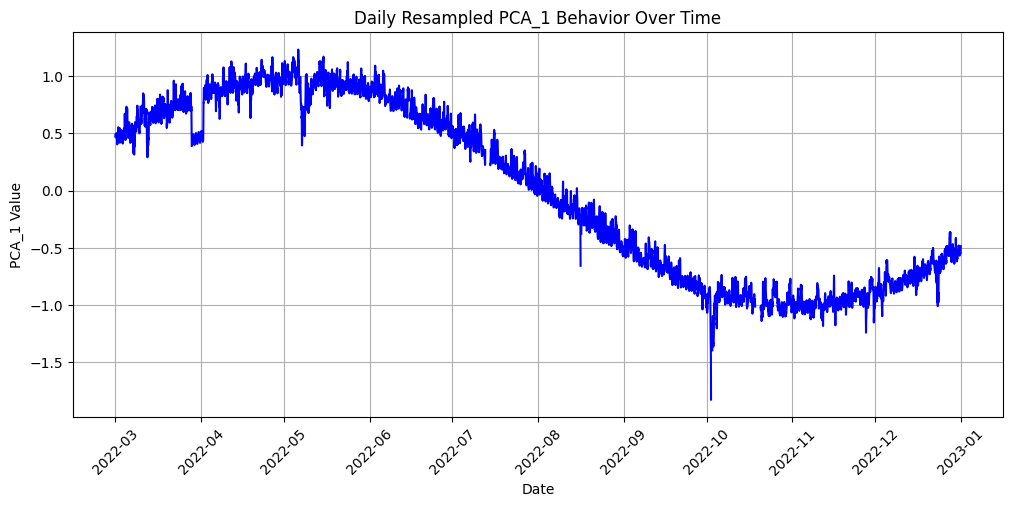

In [70]:
import matplotlib.pyplot as plt

# Ensure the StampTime column is in datetime format
# df_pca_wst['StampTime'] = pd.to_datetime(df_pca_wst['StampTime'])

# Resample PCA_1 data by day (mean value per day)
df_daily = df_pca_wst.resample('H', on='StampTime').mean()

# Plot PCA_1 over time with daily resampling
plt.figure(figsize=(12, 5))
# plt.plot(df_daily.index, df_daily['PCA_3'], linestyle='-', linewidth=1.5, color='b')
# plt.plot(df_daily.index, df_daily['PCA_4'], linestyle='-', linewidth=1.5, color='b')
plt.plot(df_daily.index, df_daily['PCA_3'], linestyle='-', linewidth=1.5, color='b')


plt.xlabel('Date')
plt.ylabel('PCA_1 Value')
plt.title('Daily Resampled PCA_1 Behavior Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

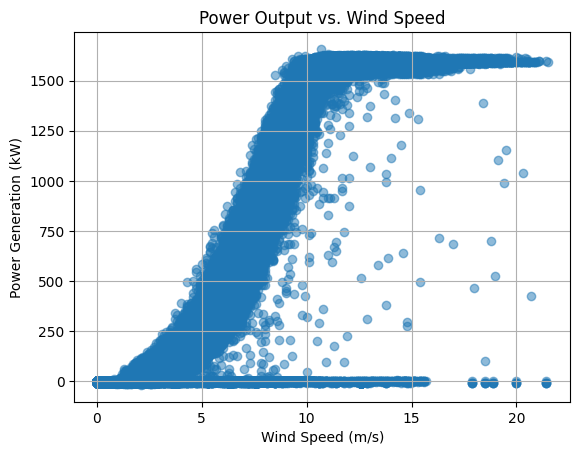

In [78]:
import matplotlib.pyplot as plt

plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Power Output vs. Wind Speed')
plt.grid(True)
plt.show()


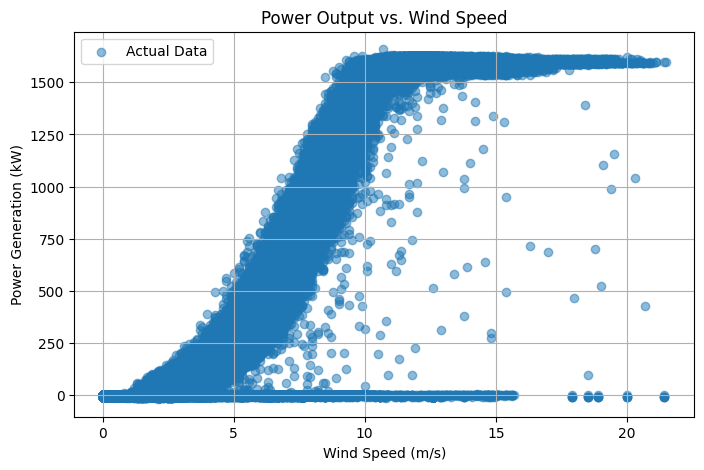

/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


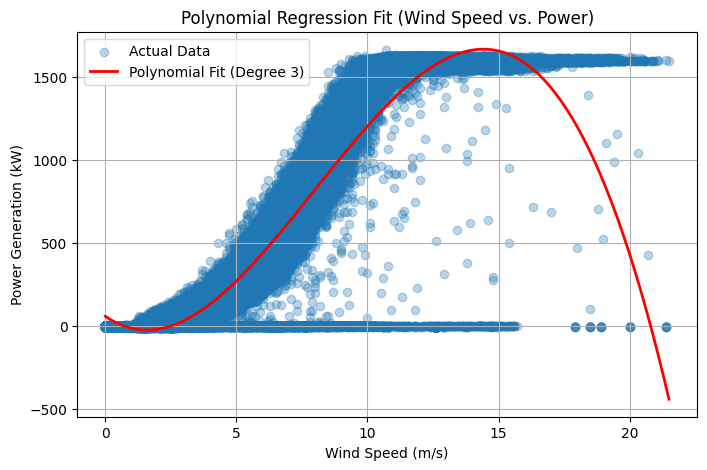

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed^2,WindSpeed^3,WindSpeed*Hour
0,T01,2022-03-01,4.5,219.0,187.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-2.831942,-3.497157,20.25,91.125,0.0
1,T02,2022-03-01,4.9,151.0,282.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,2.375567,-4.285637,24.01,117.649,0.0
2,T03,2022-03-01,6.0,276.0,319.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-5.967131,0.627171,36.00,216.000,0.0
3,T04,2022-03-01,4.1,166.0,171.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.991880,-3.978212,16.81,68.921,0.0
4,T05,2022-03-01,4.8,171.0,-10.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.750885,-4.740904,23.04,110.592,0.0


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Scatter plot to visualize non-linearity between Wind Speed and Power Generation
plt.figure(figsize=(8, 5))
plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.5, label='Actual Data')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Power Output vs. Wind Speed')
plt.grid(True)
plt.legend()
plt.show()

# Fit a Polynomial Regression Model (Degree 3 for typical wind power curves)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(df[['WindSpeed']])
model = LinearRegression().fit(X_poly, df['PowerkW'])

# Generate predictions
wind_speed_range = np.linspace(df['WindSpeed'].min(), df['WindSpeed'].max(), 100).reshape(-1, 1)
power_predictions = model.predict(poly.transform(wind_speed_range))

# Plot polynomial regression fit
plt.figure(figsize=(8, 5))
plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.3, label='Actual Data')
plt.plot(wind_speed_range, power_predictions, color='r', linewidth=2, label='Polynomial Fit (Degree 3)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Polynomial Regression Fit (Wind Speed vs. Power)')
plt.grid(True)
plt.legend()
plt.show()

# Feature Engineering: Creating new non-linear features
df['WindSpeed^2'] = df['WindSpeed'] ** 2
df['WindSpeed^3'] = df['WindSpeed'] ** 3
df['WindSpeed*Hour'] = df['WindSpeed'] * df['Hour_sin']

# Display the first few rows with new features
df.head()


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.807788  0.001873 -0.196328 -0.935924  1.125572  1.393263  1.703243   
1 -0.599457  0.022319 -0.184405 -0.935949  1.125901  1.398820  1.680554   
2 -0.194959  0.066311 -0.176137 -0.935920  1.126381  1.407171  1.624461   
3 -0.937672 -0.011827 -0.199806 -0.935930  1.125417  1.390302  1.720400   
4 -0.896428 -0.002970 -0.216263 -0.935837  1.125259  1.388798  1.701310   

        PC8       PC9      PC10      PC11  StampTime  
0 -0.160876  0.016735  0.092905 -0.037800 2022-03-01  
1 -0.048913  0.015193  0.089690 -0.042038 2022-03-01  
2 -0.089978  0.060467  0.272274 -0.019802 2022-03-01  
3 -0.166402 -0.000653  0.022178 -0.039260 2022-03-01  
4 -0.456476  0.078278  0.334683 -0.013399 2022-03-01  
Explained Variance Ratio: [3.35627989e-01 1.68803409e-01 1.06614865e-01 9.09128072e-02
 9.09059811e-02 9.07983513e-02 7.08006997e-02 2.66292545e-02
 1.13156233e-02 7.39563264e-03 1.95387902e-04]


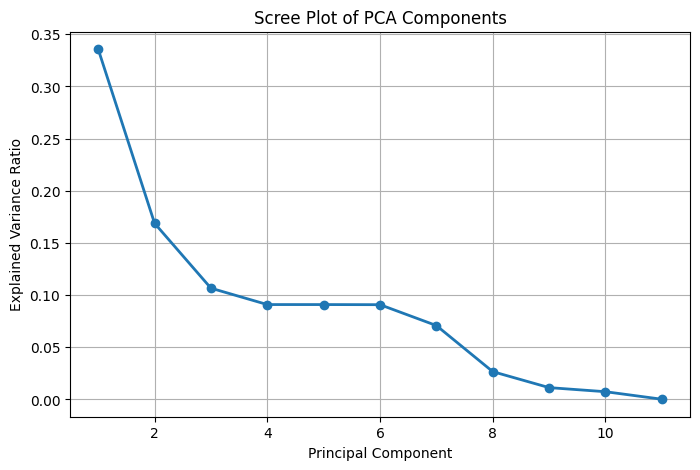

In [80]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecting the features for PCA
features = ['WindSpeed', 'PowerkW', 'Day_sin', 'Day_cos', 'Hour_sin', 'Hour_cos', 
            'Minute_sin', 'Minute_cos', 'WindSpeed^2', 'WindSpeed^3', 'WindSpeed*Hour']

# Standardizing the data before PCA (PCA requires normalization)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

# Applying PCA
pca = PCA(n_components=len(features))  # Keep all components initially
df_pca_transformed = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(len(features))]
df_pca_result = pd.DataFrame(df_pca_transformed, columns=pca_columns)
df_pca_result['StampTime'] = df_pca_wst['StampTime']  # Add timestamp for time-based analysis

# Explained variance of each principal component
explained_variance = pca.explained_variance_ratio_

# Display first few rows of the transformed PCA DataFrame
print(df_pca_result.head())

# Print explained variance
print("Explained Variance Ratio:", explained_variance)

# Scree Plot for variance explained
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), explained_variance, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()


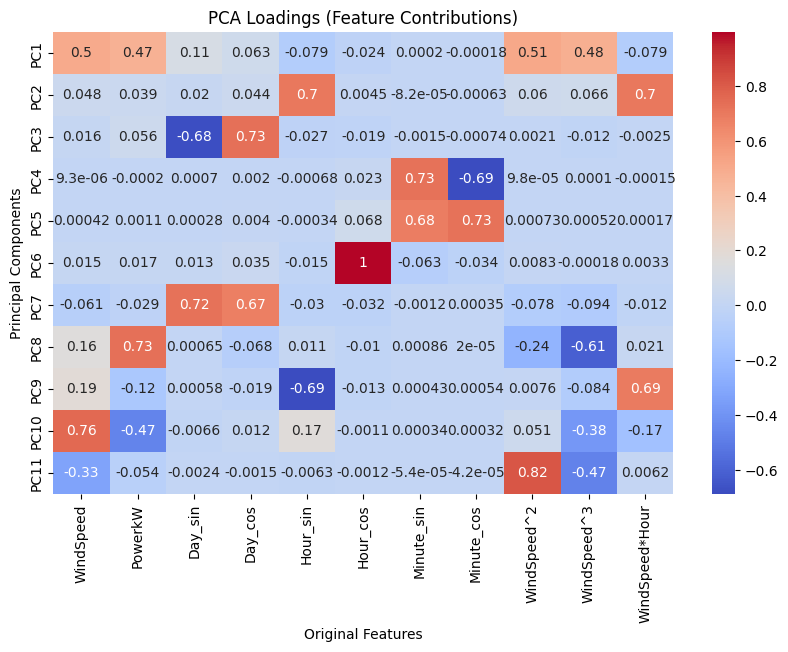

In [81]:

plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_, cmap="coolwarm", annot=True, xticklabels=features, yticklabels=pca_columns)
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions)")
plt.show()

### 📊 Interpretation of PCA Components

#### 🔍 Understanding the PCA Loadings Matrix
The **PCA loadings matrix** shows how each **original feature** contributes to each **principal component (PCA_1, PCA_2, ..., PCA_7)**.

Each row represents a **principal component**, and each column represents the **original feature** (`WindSpeed`, `PowerkW`, `Day_sin`, etc.).  
- **High positive values (close to 1 or -1):** Strong influence from that feature.  
- **Values close to 0:** That feature has little impact on that component.

---

### 🔹 Breakdown of PCA Components

#### **PCA_1 (First Component)**
- **PowerkW dominates (0.9999)** → PCA_1 primarily captures **power output variations**.
- **WindSpeed has very little impact (0.0055)** → This suggests that power output in this dataset is **less directly correlated to wind speed**.

📌 **What This Means:**  
- **PCA_1 is mainly a "Power Output Trend" component.**
- If you analyze PCA_1 over time, it tells **how power output fluctuates independently of wind speed**.

---

### 🟡 **PCA_2**
- **WindSpeed dominates (0.9978)** → PCA_2 captures **wind speed variations**.
- **PowerkW has a very small impact (-0.0055)** → Wind speed and power output behave **independently in this dataset**.

📌 **What This Means:**  
- **PCA_2 represents "Wind Speed Trends".**  
- It is mostly independent of **power generation**, meaning **other factors (wake effects, turbine efficiency) may affect power more than wind speed alone.**

---

### 🟠 **PCA_3**
- **Day_sin (0.8503) and Day_cos (-0.5206) dominate** → PCA_3 captures **daily patterns** (day-night cycles).

📌 **What This Means:**  
- **PCA_3 represents daily wind-energy trends.**  
- If **PCA_3 fluctuates over time**, it means wind speed and power generation **depend on the time of day**.  
- **Strong negative loading for `Day_cos`** suggests differences **between morning and evening wind patterns**.

---

### 🔵 **PCA_4**
- **Minute_sin (0.9366) dominates, Minute_cos (-0.3421) is also strong**  

📌 **What This Means:**  
- **PCA_4 represents short-term wind fluctuations (minute-scale trends).**  
- **If PCA_4 shows high variation**, it means wind speed and power output change **rapidly within short time intervals**.  

---

### 🟣 **PCA_5**
- **Minute_sin (0.9392) and Minute_cos (0.3392) dominate** → Similar to PCA_4 but slightly different in capturing **minute-based periodic changes**.

📌 **What This Means:**  
- **PCA_5 represents another short-term wind-energy pattern, but different from PCA_4.**  
- It may indicate **turbulent or inconsistent wind behavior.**  

---

### 🟤 **PCA_6**
- **Hour_cos (0.9141) and Hour_sin (-0.3950) dominate** → PCA_6 captures **hourly wind-energy trends**.

📌 **What This Means:**  
- **PCA_6 represents hourly wind patterns** (e.g., wind speed peaking in the afternoon, lower at night).  

---

### 🟡 **PCA_7**
- **Hour_sin (0.9143) and Hour_cos (0.3964) dominate** → Similar to PCA_6, this also represents **hourly wind-energy behavior**.

📌 **What This Means:**  
- **PCA_7 represents another variation in hourly wind speed and power generation trends.**  
- This component might separate **morning and evening wind behaviors.**  

---

## **🔹 Summary: What Do These PCA Components Explain?**

| **PCA Component** | **Main Influencing Features** | **What It Represents** |
|------------------|----------------------------|------------------------|
| **PCA_1** | **PowerkW (0.9999)** | **Power output variations (independent of wind speed)** |
| **PCA_2** | **WindSpeed (0.9978)** | **Wind speed patterns (independent of power output)** |
| **PCA_3** | **Day_sin (0.8503), Day_cos (-0.5206)** | **Daily wind-energy cycles (morning vs. evening trends)** |
| **PCA_4** | **Minute_sin (0.9366), Minute_cos (-0.3421)** | **Short-term wind fluctuations (minute-scale variations)** |
| **PCA_5** | **Minute_sin (0.9392), Minute_cos (0.3392)** | **Another short-term wind variation pattern** |
| **PCA_6** | **Hour_cos (0.9141), Hour_sin (-0.3950)** | **Hourly wind-energy trends** |
| **PCA_7** | **Hour_sin (0.9143), Hour_cos (0.3964)** | **Another hourly wind-energy pattern (morning vs. afternoon effects)** |

---

## **🚀 Next Steps**
✅ **Do you want to plot PCA components over time to see trends?**  
✅ **Would you like to cluster the PCA results to group similar wind-energy behaviors?**  
✅ **Do you want to compare PCA-based clusters with actual wind-energy production?**  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select only the PCA components for clustering
pca_features = df_pca[["PCA_1", "PCA_2", "PCA_3"]]  # Use the first 3 components

# Standardize the PCA features (not always necessary, but ensures consistency)
scaler = StandardScaler()
pca_features_scaled = scaler.fit_transform(pca_features)

# Apply the Elbow Method to determine the optimal number of clusters (K)
distortions = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_features_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion (Inertia)")
plt.title("Elbow Method to Determine Optimal K")
plt.grid(True)
plt.show()




In [ ]:
# Choose the optimal K based on the elbow point
optimal_k = 3  # Manually set based on the elbow plot

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca["Cluster_KMeans"] = kmeans.fit_predict(pca_features_scaled)

# Save the dataset with cluster labels
# df_pca.to_csv("KMeans_Clustered_PCA_Data.csv", index=False)

# Display the first few rows of the dataset
print(df_pca.head())

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(df_pca["PCA_1"], df_pca["PCA_2"], c=df_pca["Cluster_KMeans"], cmap="viridis", alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-means Clustering in PCA Space (K={optimal_k})")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_pca["StampTime"], df_pca["Cluster_KMeans"], marker="o", linestyle="-", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Cluster ID")
plt.title("Cluster Transitions Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
df["Cluster_KMeans"] = df_pca["Cluster_KMeans"]

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_pca["Cluster_KMeans"], y=df["WindSpeed"])
plt.xlabel("Cluster ID")
plt.ylabel("Wind Speed Variability (u_std)")
plt.title("Wind Variability Across Clusters")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_pca["Cluster_KMeans"], y=df["PowerkW"])
plt.xlabel("Cluster ID")
plt.ylabel("Power Output Variability")
plt.title("Power Variability Across Clusters")
plt.grid(True)
plt.show()


In [ ]:
df

In [ ]:
df[df.isna().any(axis=1)]

In [ ]:
# Group by timestamp and compute standard deviation for u, v, and power output
df_std = df.groupby("StampTime").agg({
    "u_vector": "std",
    "v_vector": "std",
    "PowerkW": "std"
}).reset_index()

# Rename columns for clarity
df_std.rename(columns={
    "u_vector": "u_std",
    "v_vector": "v_std",
    "PowerkW": "power_std"
}, inplace=True)

In [ ]:
df_std

In [ ]:
# Select numerical columns for PCA (exclude timestamp)
features = df_std[['u_std', 'v_std', 'power_std']]  # Adjust if necessary

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
pca_transformed = pca.fit_transform(features_scaled)

# Explained variance plot to determine the number of components to keep
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
# Determine optimal number of components (e.g., keep enough to explain ~95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components}")

# Apply PCA with optimal components
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(features_scaled)

# Convert PCA results to DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
df_pca_std = pd.DataFrame(pca_features, columns=pca_columns)
df_pca_std["StampTime"] = df_std["StampTime"].values  # Retain timestamp for reference

In [ ]:
# Select only the PCA components for clustering
pca_features = df_pca_std[["PCA_1", "PCA_2", "PCA_3"]]  # Use the first 3 components

# Standardize the PCA features (not always necessary, but ensures consistency)
scaler = StandardScaler()
pca_features_scaled = scaler.fit_transform(pca_features)

# Apply the Elbow Method to determine the optimal number of clusters (K)
distortions = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_features_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion (Inertia)")
plt.title("Elbow Method to Determine Optimal K")
plt.grid(True)
plt.show()



In [ ]:
# Convert StampTime to datetime
df["StampTime"] = pd.to_datetime(df["StampTime"])

# Pivot dataset to represent wind conditions at each timestamp
df_pivot = df.pivot(index="StampTime", columns="Turbine", values=["u_vector", "v_vector", "PowerkW"])

# Flatten multi-index columns
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot.reset_index(inplace=True)

In [ ]:


# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_pivot.iloc[:,1:])

# Apply PCA
pca = PCA()
pca_transformed = pca.fit_transform(features_scaled)

# Explained variance plot to determine the number of components to keep
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
# Determine optimal number of components (e.g., keep enough to explain ~95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components}")

In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(features_scaled)

In [ ]:
# Convert PCA results to DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
df_pca = pd.DataFrame(pca_features, columns=pca_columns)

In [ ]:
df_pca

In [ ]:
pca.components_

In [ ]:
# Visualize PCA Component Contribution (Loadings)
plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_, cmap="coolwarm", annot=True, xticklabels=df_pivot.iloc[:,1:].columns, yticklabels=pca_columns)
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions)")
plt.show()

In [ ]:
# Plot explained variance of each PCA component
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each PCA Component")
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df_pca.index, df_pca["PCA_1"], label="PCA_1 (Overall Wind-Energy Pattern)", linestyle="-")
plt.plot(df_pca.index, df_pca["PCA_2"], label="PCA_2 (Directional Variations)", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("PCA Score")
plt.title("Wind-Energy Patterns Over Time (PCA Components)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df_pivot

In [ ]:
# PCA explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Number of components
num_components = np.arange(1, len(explained_variance_ratio) + 1)

# Scree Plot (Explained Variance per Component)
plt.figure(figsize=(8, 5))
plt.plot(num_components, explained_variance_ratio, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()

# Cumulative Variance Explained Plot
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(num_components, cumulative_variance, marker='s', linestyle='-', linewidth=2, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.9, color='gray', linestyle='--', label='90% Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import math

def calculate_azimuth(lat1, lon1, lat2, lon2):
    """
    Calculate the azimuth (bearing) from point A (lat1, lon1) to point B (lat2, lon2).
    """
    d_lon = math.radians(lon2 - lon1)
    lat1, lat2 = map(math.radians, [lat1, lat2])

    x = math.sin(d_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))

    azimuth = math.degrees(math.atan2(x, y))
    return azimuth % 360  # Normalize to 0-360 degrees

# Example usage
lat1, lon1 = 39.947, -75.200  # Example point A (Philadelphia)
lat2, lon2 = 40.730, -73.935  # Example point B (New York City)

azimuth = calculate_azimuth(lat1, lon1, lat2, lon2)
print(f"Azimuth from A to B: {azimuth:.2f}°")


In [ ]:
import math
import geopandas as gpd
from shapely.geometry import Polygon

def calculate_azimuth(lat1, lon1, lat2, lon2):
    """
    Calculate the azimuth (bearing) from one point to another.
    """
    d_lon = math.radians(lon2 - lon1)
    lat1, lat2 = map(math.radians, [lat1, lat2])

    x = math.sin(d_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))

    azimuth = math.degrees(math.atan2(x, y))
    return azimuth % 360  # Normalize to 0-360 degrees

def azimuths_of_polygon(polygon):
    """
    Compute azimuths for each edge of a polygon.
    """
    coords = list(polygon.exterior.coords)
    azimuths = []

    for i in range(len(coords) - 1):  # Loop through edges
        lat1, lon1 = coords[i]
        lat2, lon2 = coords[i + 1]
        azimuths.append(calculate_azimuth(lat1, lon1, lat2, lon2))

    return azimuths

# Example Polygon (replace with actual wind farm coordinates)
polygon = Polygon([
    (39.9, -75.200),
    (39.85, -75.150),
    (39.8, -75.2),
    (39.85, -75.25),
    (39.9, -75.200)  # Closing the loop
])

azimuths = azimuths_of_polygon(polygon)
print("Azimuths of each edge:", azimuths)


# To add later